In [21]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [13]:
train = pd.read_csv('../data/train/train_ratings.csv')
directors = pd.read_csv('../data/train/directors.tsv', sep="\t")
genres = pd.read_csv('../data/train/genres.tsv', sep="\t")
titles = pd.read_csv('../data/train/titles.tsv', sep="\t")
writers = pd.read_csv('../data/train/writers.tsv', sep="\t")
years = pd.read_csv('../data/train/years.tsv', sep="\t")

In [14]:
directors = directors.groupby('item')['director'].apply(list).reset_index()
genres = genres.groupby('item')['genre'].apply(list).reset_index()
writers = writers.groupby('item')['writer'].apply(list).reset_index()

## 제목 전처리
- 관사(A,An,The) 순서 교정 

In [4]:
titles[titles['title'].str.contains(r', (A|An|The)\b', regex=True)]

/tmp/ipykernel_429161/1282412968.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  titles[titles['title'].str.contains(r', (A|An|The)\b', regex=True)]


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
5,4993,"Lord of the Rings: The Fellowship of the Ring,..."
6,7153,"Lord of the Rings: The Return of the King, The..."
7,5952,"Lord of the Rings: The Two Towers, The (2002)"
...,...,...
6772,110771,"Other Woman, The (2014)"
6778,32302,"League of Ordinary Gentlemen, A (2004)"
6794,92509,"Vow, The (2012)"
6798,113378,"Giver, The (2014)"


In [15]:
titles["title"] = titles["title"].apply(lambda x: 'The ' + x.replace(', The', '') if ', The' in x else x)
titles["title"] = titles["title"].apply(lambda x: 'A ' + x.replace(', A', '') if ', A' in x else x)
titles["title"] = titles["title"].apply(lambda x: 'An ' + x.replace(', An', '') if ', An' in x else x)

## 작가 수와 평점 수 관계
-  작가수가 5명이 넘어가는 영화는 많지 않은 편 (6명 이상인 영화는 100개 미만)
- boxplot으로 보면 median 값은 크게 차이는 않나지만 치우친 분포로 인해 평균 값은 차이가 난다.

In [16]:
# 데이터 결합
train_df = train.merge(directors, how = 'left')
train_df = train_df.merge(genres, how = 'left')
train_df = train_df.merge(titles, how = 'left')
train_df = train_df.merge(writers, how = 'left')
train_df = train_df.merge(years, how = 'left')

In [17]:
train_df.head()

,user,item,time,director,genre,title,writer,year
0,11,4643,1230782529,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]",Planet of the Apes (2001),"[nm0099541, nm0115310, nm0465199, nm0742797]",2001.0
1,11,170,1230782534,[nm0812200],"[Action, Adventure, Crime, Thriller]",Hackers (1995),NaN,1995.0
2,11,531,1230782539,[nm0002140],"[Children, Drama]",The Secret Garden (1993),"[nm0003031, nm0122364]",1993.0
3,11,616,1230782542,[nm0718627],"[Animation, Children]",The Aristocats (1970),"[nm0027011, nm0166307, nm0166551, nm0314788, n...",1970.0
4,11,2140,1230782563,"[nm0000568, nm0001345]","[Adventure, Fantasy]",The Dark Crystal (1982),"[nm0001345, nm0643973]",1982.0


In [18]:
# 작가 수 변수 생성
train_df['n_writer'] = train_df.writer.apply(lambda x : len(x) if x is not np.nan else x)

In [ ]:
temp = train_df.groupby(['item', 'n_writer']).size().reset_index(name = 'count')

# 작가 수별 영화 빈도
temp.n_writer.value_counts()

n_writer
1.0     2660
2.0     1681
3.0      699
4.0      323
5.0      137
6.0       67
7.0       26
8.0       17
9.0       11
10.0       8
11.0       4
16.0       3
21.0       2
18.0       2
19.0       2
12.0       2
24.0       1
23.0       1
15.0       1
17.0       1
Name: count, dtype: int64

<Axes: xlabel='n_writer', ylabel='count'>

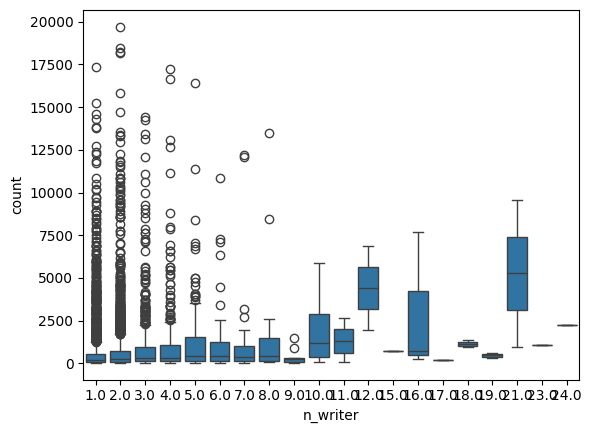

In [ ]:
# 박스플랏
sns.boxplot(x='n_writer', y='count', data = temp)

Text(0, 0.5, 'avg_count')

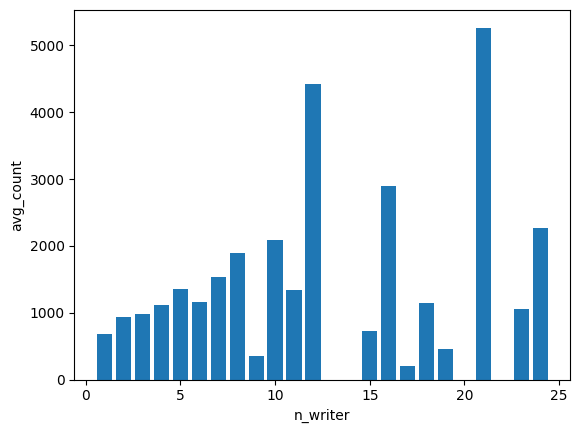

In [ ]:
# 막대그래프
temp2 = temp.groupby('n_writer')['count'].mean().reset_index()
plt.bar(x = 'n_writer', height ='count', data = temp2)
plt.xlabel('n_writer')
plt.ylabel('avg_count')

## 제목 유사도와 평점 유저 유사도
- 시리즈물은 사용자 유사도가 높게 나타난다.
- text embedding을 활용할 수 있는 방향으로 모델 선택 또는 피처 생성 필요

In [ ]:
def clean_title(title):
    pattern = r'\s*\(\d{4}\)|\s+(?:Part|Chapter|Episode)?\s*(?:[0-9]+|[IVXLCDM]+)$'
    return re.sub(pattern, '', title.lower().strip())

In [25]:
# 유사도 계산을 위해 제목 정제
titles['clean_title'] = titles['title'].apply(clean_title)
titles.head()

,item,title,clean_title
0,318,The Shawshank Redemption (1994),the shawshank redemption
1,2571,The Matrix (1999),the matrix
2,2959,Fight Club (1999),fight club
3,296,Pulp Fiction (1994),pulp fiction
4,356,Forrest Gump (1994),forrest gump


In [29]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

class OptimizedSimilarityAnalyzer:
    def __init__(self, ratings_df, movies_df, user_col='user', movie_col='item', 
                 title_col='clean_title', batch_size=1000):
        """
        최적화된 유사도 분석기
        
        Parameters:
        batch_size: 배치 처리 크기 (메모리 사용량 조절)
        """
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.user_col = user_col
        self.movie_col = movie_col
        self.title_col = title_col
        self.batch_size = batch_size
        
        # 사용자-영화 희소 행렬 미리 계산
        self._create_sparse_matrix()
        
        # 문장 임베딩 모델 로드
        self.model = SentenceTransformer('all-mpnet-base-v2')
    
    def _create_sparse_matrix(self):
        """효율적인 사용자-영화 희소 행렬 생성"""
        # 인덱스 매핑 생성
        self.user_mapping = {uid: idx for idx, uid in 
                           enumerate(self.ratings_df[self.user_col].unique())}
        self.movie_mapping = {mid: idx for idx, mid in 
                            enumerate(self.movies_df[self.movie_col])}
        
        # 희소 행렬 생성
        user_idx = [self.user_mapping[u] for u in self.ratings_df[self.user_col]]
        movie_idx = [self.movie_mapping[m] for m in self.ratings_df[self.movie_col]]
        ratings = np.ones_like(user_idx)  # 시청 여부만 고려
        
        self.user_movie_matrix = csr_matrix(
            (ratings, (movie_idx, user_idx)),
            shape=(len(self.movie_mapping), len(self.user_mapping))
        )
    
    def compute_title_similarities_batch(self):
        """배치 처리를 통한 제목 유사도 계산"""
        titles = self.movies_df[self.title_col].tolist()
        n_movies = len(titles)
        
        # 임베딩 계산 (배치 처리)
        embeddings = []
        for i in range(0, n_movies, self.batch_size):
            batch_titles = titles[i:i + self.batch_size]
            batch_embeddings = self.model.encode(batch_titles)
            embeddings.append(batch_embeddings)
        
        embeddings = np.vstack(embeddings)
        
        # 정규화된 코사인 유사도 계산
        normalized_embeddings = normalize(embeddings)
        title_similarities = normalized_embeddings @ normalized_embeddings.T
        
        return title_similarities
    
    def compute_user_similarities_efficient(self):
        """효율적인 Jaccard 유사도 계산"""
        # 행렬의 각 행에 대한 1의 개수 계산 (각 영화의 시청자 수)
        row_sums = np.array(self.user_movie_matrix.sum(axis=1)).flatten()
        
        # 영화 쌍 간의 공통 시청자 수 계산
        intersection = (self.user_movie_matrix @ self.user_movie_matrix.T).toarray()
        
        # 각 쌍의 합집합 크기 계산: |A ∪ B| = |A| + |B| - |A ∩ B|
        union = np.add.outer(row_sums, row_sums) - intersection
        
        # Jaccard 유사도 계산: |A ∩ B| / |A ∪ B|
        # 0으로 나누는 것을 방지하기 위해 epsilon 추가
        epsilon = 1e-10
        user_similarities = intersection / (union + epsilon)
        
        return user_similarities
    
    def analyze_correlations(self):
        """최적화된 상관관계 분석"""
        # 유사도 행렬 계산
        print("제목 유사도 계산 중...")
        title_similarities = self.compute_title_similarities_batch()
        
        print("사용자 유사도 계산 중...")
        user_similarities = self.compute_user_similarities_efficient()
        
        # 상부 삼각행렬만 추출 (메모리 효율성)
        mask = np.triu_indices_from(title_similarities, k=1)
        title_sim_vector = title_similarities[mask]
        user_sim_vector = user_similarities[mask]
        
        # 상관관계 분석
        pearson_corr, pearson_p = pearsonr(title_sim_vector, user_sim_vector)
        spearman_corr, spearman_p = spearmanr(title_sim_vector, user_sim_vector)
        
        # 높은 유사도 분석
        high_sim_threshold = 0.8
        high_sim_mask = title_sim_vector >= high_sim_threshold
        
        high_sim_user_overlap = np.mean(user_sim_vector[high_sim_mask])
        low_sim_user_overlap = np.mean(user_sim_vector[~high_sim_mask])
        
        results = {
            'pearson': {'correlation': pearson_corr, 'p_value': pearson_p},
            'spearman': {'correlation': spearman_corr, 'p_value': spearman_p},
            'high_sim_analysis': {
                'threshold': high_sim_threshold,
                'high_sim_user_overlap': high_sim_user_overlap,
                'low_sim_user_overlap': low_sim_user_overlap
            },
            'title_similarities': title_similarities,
            'user_similarities': user_similarities
        }
        
        return results
    
    def find_top_pairs(self, results, n_pairs=10):
        """효율적인 상위 유사 쌍 찾기"""
        title_sims = results['title_similarities']
        user_sims = results['user_similarities']
        
        # 상위 인덱스 찾기 (마스킹 사용)
        mask = np.triu_indices_from(title_sims, k=1)
        title_sim_pairs = [(i, j, title_sims[i,j], user_sims[i,j]) 
                            for i, j in zip(*mask)]
        
        # 정렬 및 상위 쌍 선택
        title_sim_pairs.sort(key=lambda x: x[2], reverse=True)
        top_title_pairs = title_sim_pairs[:n_pairs]
        
        title_sim_pairs.sort(key=lambda x: x[3], reverse=True)
        top_user_pairs = title_sim_pairs[:n_pairs]
        
        # 결과 데이터프레임 생성
        def create_pairs_df(pairs):
            return pd.DataFrame([{
                'movie1': self.movies_df.iloc[i][self.title_col],
                'movie2': self.movies_df.iloc[j][self.title_col],
                'title_similarity': title_sim,
                'user_similarity': user_sim
            } for i, j, title_sim, user_sim in pairs])
        
        return create_pairs_df(top_title_pairs), create_pairs_df(top_user_pairs)

    def visualize_results(self, results, sample_size=10000):
        """효율적인 시각화"""
        plt.figure(figsize=(15, 5))
        
        # 샘플링을 통한 산점도 생성
        mask = np.triu_indices_from(results['title_similarities'], k=1)
        title_sims = results['title_similarities'][mask]
        user_sims = results['user_similarities'][mask]
        
        if len(title_sims) > sample_size:
            idx = np.random.choice(len(title_sims), sample_size, replace=False)
            title_sims = title_sims[idx]
            user_sims = user_sims[idx]
        
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=title_sims, y=user_sims, alpha=0.1)
        plt.title('Title vs User Similarity (Sampled)')
        plt.xlabel('Title Similarity')
        plt.ylabel('User Overlap Similarity')
        
        plt.subplot(1, 2, 2)
        sim_types = ['High Title Similarity', 'Low Title Similarity']
        user_overlaps = [
            results['high_sim_analysis']['high_sim_user_overlap'],
            results['high_sim_analysis']['low_sim_user_overlap']
        ]
        sns.barplot(x=sim_types, y=user_overlaps)
        plt.title('User Overlap by Title Similarity Group')
        plt.ylabel('Average User Overlap')
        
        plt.tight_layout()
        return plt

def run_optimized_analysis(ratings_df, movies_df):
    """최적화된 분석 실행 함수"""
    print("분석 시작...")
    analyzer = OptimizedSimilarityAnalyzer(ratings_df, movies_df)
    
    print("상관관계 분석 중...")
    results = analyzer.analyze_correlations()
    
    print("상위 유사 쌍 찾기...")
    title_sim_pairs, user_sim_pairs = analyzer.find_top_pairs(results)
    
    print("\n=== 분석 결과 ===")
    print(f"\n1. Pearson 상관계수: {results['pearson']['correlation']:.3f}")
    print(f"   p-value: {results['pearson']['p_value']:.3e}")
    
    print(f"\n2. Spearman 상관계수: {results['spearman']['correlation']:.3f}")
    print(f"   p-value: {results['spearman']['p_value']:.3e}")
    
    # 시각화
    analyzer.visualize_results(results)
    
    return results, title_sim_pairs, user_sim_pairs

분석 시작...
상관관계 분석 중...
제목 유사도 계산 중...
사용자 유사도 계산 중...
상위 유사 쌍 찾기...

=== 분석 결과 ===

1. Pearson 상관계수: 0.146
   p-value: 0.000e+00

2. Spearman 상관계수: 0.104
   p-value: 0.000e+00


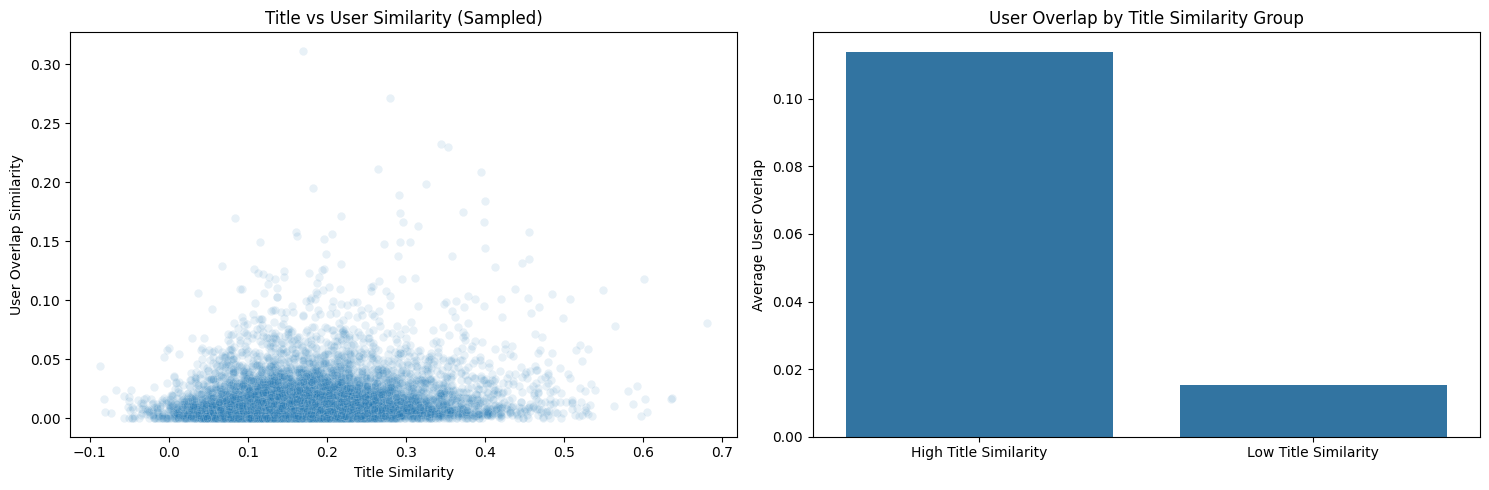

In [30]:
results, title_sim_pairs, user_sim_pairs = run_optimized_analysis(train_df, titles)

In [ ]:
# 사용자 유사도 상위 조합
user_sim_pairs

,movie1,movie2,title_similarity,user_similarity
0,the lord of the rings: the fellowship of the ring,the lord of the rings: the two towers,0.767980,0.790034
1,the lord of the rings: the return of the king,the lord of the rings: the two towers,0.772977,0.788912
2,the lord of the rings: the fellowship of the ring,the lord of the rings: the return of the king,0.804153,0.779721
3,star wars: episode iv - a new hope,star wars: episode v - the empire strikes back,0.864625,0.754596
4,samurai ii: duel at ichijoji temple (zoku miya...,samurai iii: duel on ganryu island (a.k.a. bus...,0.739607,0.746835
5,star wars: episode v - the empire strikes back,star wars: episode vi - return of the jedi,0.893173,0.710495
6,kill bill: vol. 1,kill bill: vol. 2,0.986061,0.696096
7,star wars: episode iv - a new hope,star wars: episode vi - return of the jedi,0.876931,0.692412
8,nymphomaniac: volume i,nymphomaniac: volume ii,0.986365,0.635036
9,the godfather,the godfather: part ii,0.877364,0.618374
